# Cross Validation Multiple classifier testing

In this document, we can apply multiple classifiers for empathy and obtain the average metrics for each of the folds. The folds have been previously managed by WEKA. We have five available folds each divided into a training and testing dataset using the following format:

*   Empathyabase-'+(number of fold)+'tra.csv  for the training set
*   Empathyabase-'+(number of fold)+'tst.csv  for the test set

In this document, we carry out multi-fold analysis and obtain an average performance review of all the classifiers in conjunction. The output includes a document for each of the folds that contains all the patterns obtained from the PBC4cip classifier, as well as their confusion matrices and three classification metrics. The format for this output files are:

*   PBC4CIP_values_'+(number of fold)+'.txt


### WARNING: The PBC4cip python implementation takes a long time to run. Around an hour per fold. It is much more maneagable to carry out the classification process using this specific classifier in WEKA



In [1]:
pip install pbc4cip

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.4/57.4 kB 1.9 MB/s eta 0:00:00


In [2]:
#Importing of libraries necessary for classification and manipulation of database.

import pandas as pd
import numpy as np
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import recall_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import OneClassSVM
from sklearn.metrics import precision_score
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from gensim.test.utils import common_texts
from string import punctuation
import numpy as np
from gensim.models import Word2Vec, KeyedVectors
import gensim
import gensim.downloader as gensim_api
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split

from PBC4cip import PBC4cip
import os
import argparse
import numpy as np
import pandas as pd

from tqdm import tqdm, trange
from PBC4cip import PBC4cip
from PBC4cip.core.Evaluation import obtainAUCMulticlass
from PBC4cip.core.Helpers import get_col_dist, get_idx_val


## Creation of classifiers

In [3]:
#Creation of classifiers
rfc = RandomForestClassifier(max_depth=10, random_state=0)
knn = KNeighborsClassifier(n_neighbors=5)
#lreg = LogisticRegression(random_state = 0, penalty = 'l2')
GNB = GaussianNB()
dtc = DecisionTreeClassifier(random_state=0)
xb = XGBClassifier()
nn = MLPClassifier()
pbc = PBC4cip(tree_count = 100) # 100 tree cound og


#Generation of classification array
classifiers = [rfc,knn,GNB,dtc,nn,pbc]
#classifiers = [rfc,knn,GNB,dtc,nn]  # NO PBC4cip
#For visualization of classification array
#class_names = ['Random Forest','KNN','Gaussian NB','dtc','MLP'] #NO PBC4cip
class_names = ['Random Forest','KNN','Gaussian NB','dtc','MLP','PBC4CIP']

## Classification

In [5]:
#Values for performance measures on each of the classifiers is stored in the arrays
acc_array_skf = []
rec_array_skf= []
auc_array_skf = []
pre_array_skf = []


#Scoring function for PBC4CIP
def score(predicted, y):
        y_class_dist = get_col_dist(y[f'{y.columns[0]}'])
        real = list(map(lambda instance: get_idx_val(y_class_dist, instance), y[f'{y.columns[0]}']))
        numClasses = len(y_class_dist)
        confusion = [[0]* numClasses for i in range(numClasses)]
        classified_as = 0
        error_count = 0

        for i in range(len(real)):
            if real[i] != predicted[i]:
                error_count = error_count + 1
            confusion[real[i]][predicted[i]] = confusion[real[i]][predicted[i]] + 1

        acc = 100.0 * (len(real) - error_count) / len(real)
        auc = obtainAUCMulticlass(confusion, numClasses)

        return confusion, acc, auc


for cls in classifiers:
  #Values for each classifier are stored in the array
  acc_list = []
  recall_list = []
  precision_list = []
  auc_list = []

  #For each of the folds

  for i in range(1,2):

    data_tra = pd.read_csv('Empathyabase-'+str(i)+'tra.csv')
    data_tst = pd.read_csv('Empathyabase-'+str(i)+'tst.csv')

    #print(data_tra.columns)

    #Preparation
    # We ensure that the variables are taken as categories and not integers or floats

    data_tra['Empathy'] = data_tra['Empathy'].astype('string')
    data_tra["utterance_idx"] = data_tra["utterance_idx"].astype('category')
    data_tra["Talker"] = data_tra["Talker"].astype('category')
    data_tra["context_encoded"] = data_tra["context_encoded"].astype('category')

    data_tst['Empathy'] = data_tst['Empathy'].astype('string')
    data_tst["utterance_idx"] = data_tst["utterance_idx"].astype('category')
    data_tst["Talker"] = data_tst["Talker"].astype('category')
    data_tst["context_encoded"] = data_tst["context_encoded"].astype('category')


    #Separate target values for both training and testing

    X1_train = data_tra.drop(columns=['Empathy'])
    Y1_train = data_tra.drop(columns=X1_train.columns)

    X1_test = data_tst.drop(columns=['Empathy'])
    Y1_test = data_tst.drop(columns=X1_test.columns)


    #For each classifier
    if str(type(cls)) != "<class 'PBC4cip.core.PBC4cip.PBC4cip'>":
      # Sci-kit statistical classifiers

      cls.fit(X1_train,Y1_train)

      y_pred = cls.predict(X1_test)
      acc_score = accuracy_score(Y1_test,y_pred)
      recall_sc = recall_score(Y1_test,y_pred,average='weighted')
      prec_score = precision_score(Y1_test,y_pred,average='weighted')

      pred_prob = cls.predict_proba(X1_test)

      pred_prob_lst = []
      for row in pred_prob:
        arr = []
        for ele in row:
          arr.append(float(ele))
        pred_prob_lst.append(arr)
      auc_sc = roc_auc_score(Y1_test['Empathy'], pred_prob_lst,multi_class='ovr')

      acc_list.append(acc_score)
      recall_list.append(recall_sc)
      precision_list.append(prec_score)
      auc_list.append(auc_sc)

    else:
      #PBC4CIP
      patterns = cls.fit(X1_train, Y1_train)

      y_test_scores = cls.score_samples(X1_test)

      with open('PBC4CIP_values_'+str(i)+'.txt', 'w') as f:
        print('Test Scores:', file=f)

        for i, test_score in enumerate(y_test_scores):
            print(f"{i}: {test_score}",file=f)

        y_pred = cls.predict(X1_test)
        confusion, acc, auc = score(y_pred, Y1_test)
        acc_list.append(acc/100)
        auc_list.append(auc)
        y_pred2 = y_pred

        for i in range(len(y_pred)):
          y_pred2[i] = str(y_pred[i])

        y_pred2 = pd.DataFrame(y_pred2)

        recall_list.append(recall_score(Y1_test, y_pred2, average='weighted'))
        precision_list.append(precision_score(Y1_test, y_pred2, average='weighted'))


        print(f"\nPatterns Found:",file=f)
        for pattern in patterns:
            print(f"{pattern}",file=f)

        print(f"\nConfusion Matrix:",file=f)
        for i in range(len(confusion[0])):
            for j in range(len(confusion[0])):
                print(f"{confusion[i][j]} ", end='',file=f)
            print("",file=f)
        print(f"\n\nacc: {acc} , auc: {auc} , numPatterns: {len(patterns)}",file=f)

  # Appending to the overall metric array for each classifier
  acc_array_skf.append(np.array(acc_list).mean())
  rec_array_skf.append(np.array(recall_list).mean())
  auc_array_skf.append(np.array(auc_list).mean())
  pre_array_skf.append(np.array(precision_list).mean())

<ipython-input-5-c0a58bf9fdf3>:71: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  cls.fit(X1_train,Y1_train)


 ## Result display

RandomForestClassifier

Average Accuracy: 0.4956268221574344

Average Recall: 0.4956268221574344

Average AUC: 0.6505283651588132

Average Precision: 0.4754789670970429

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
KNeighborsClassifier

Average Accuracy: 0.43731778425655976

Average Recall: 0.43731778425655976

Average AUC: 0.5627533323422176

Average Precision: 0.4139462255217486

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
GaussianNB

Average Accuracy: 0.13411078717201166

Average Recall: 0.13411078717201166

Average AUC: 0.5207490517234963

Average Precision: 0.31280933421708096

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
DecisionTreeClassifier

Average Accuracy: 0.446064139941691

Average Recall: 0.446064139941691

Average AUC: 0.5478050626308931

Average Precision: 0.43510048382544225

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
MLPClassifier

Average Accuracy: 0.45481049562682213

Average Recall: 0.45481049562682213

Average AUC

Text(0.5, 0, 'Classifier')

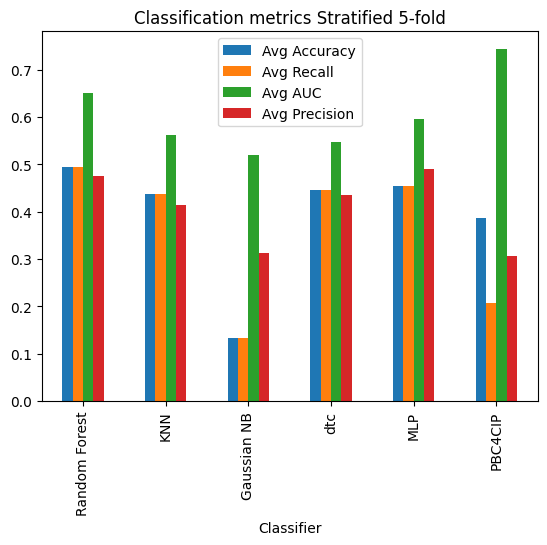

In [6]:
#Results for the average performance through the five folds.
for i in range(0,len(rec_array_skf)):
  print(type(classifiers[i]).__name__)
  print()
  print('Average Accuracy: '+str(acc_array_skf[i]))
  print()
  print('Average Recall: '+ str(rec_array_skf[i]))
  print()
  print('Average AUC: '+ str(auc_array_skf[i]))
  print()
  print('Average Precision: '+ str(pre_array_skf[i]))
  print()
  print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")


#Bar plot
plotdata = pd.DataFrame({
    "Avg Accuracy": acc_array_skf,
    "Avg Recall": rec_array_skf,
    "Avg AUC": auc_array_skf,
    "Avg Precision": pre_array_skf,
    },
    index=class_names
)
plotdata.plot(kind="bar")
plt.title("Classification metrics Stratified 5-fold")
plt.xlabel("Classifier")